# BLU05  - Exercise Notebook 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
idx = pd.IndexSlice
warnings.simplefilter(action='ignore', category=FutureWarning)   
from random import seed
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error
import math
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools
import hashlib # for grading purposes
# these are just for the asserts 
from statsmodels.tsa.statespace.sarimax import SARIMAXResultsWrapper
from statsmodels.tsa.statespace.mlemodel import PredictionResultsWrapper

from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
plt.rcParams['figure.figsize'] = (12, 4)

%matplotlib inline

# Functions

In [2]:
def get_aic(series_, params):
    p = params[0] 
    d = params[1] 
    q = params[2] 
    P = params[3]
    D = params[4] 
    Q = params[5]
    S = params[6]
    
    model = sm.tsa.statespace.SARIMAX(series_,
                                      order=(p, d, q),
                                      seasonal_order=(P, D, Q, S),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    results = model.fit(maxiter=100)
    
    return results.aic

In [3]:
def get_mae(series_, params, prediction_window):
    p = params[0] 
    d = params[1] 
    q = params[2] 
    P = params[3]
    D = params[4] 
    Q = params[5]
    S = params[6]
    
    lenght = len(series_)
    series_train = series_[:-prediction_window]
    series_test = series_[-prediction_window:]
    
    model = sm.tsa.statespace.SARIMAX(series_train,
                                      order=(p, d, q),
                                      seasonal_order=(P, D, Q, S),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)

    results = model.fit(maxiter=500)
    predictions = results.get_forecast(steps=prediction_window)
    predicted_mean_logged = predictions.predicted_mean
    predicted_mean = predicted_mean_logged
    
    return mean_absolute_error(series_test,predicted_mean)

In [4]:
def load_emissions_data():
    emissions = pd.read_csv('data/emissions.csv')
    emissions = emissions[emissions.Description=='Coal Electric Power Sector CO2 Emissions']
    emissions['YYYYMM'] = emissions['YYYYMM'].astype(str)
    emissions['YYYYMM'] = pd.to_datetime(emissions['YYYYMM'],format='%Y%m', errors='coerce').dropna()
    emissions = emissions.set_index('YYYYMM')
    emissions = emissions.sort_index()
    emissions['Value'] = emissions.Value.astype(float)
    emissions.index = emissions.index.rename('date')
    emissions = emissions['Value']
    emissions = emissions[:'2000']
    emissions = emissions.resample('M').mean()
    return emissions

# Let's predict CO2 emissions!

In [5]:
emissions = load_emissions_data()

In [6]:
emissions_train = emissions[:'1997']
emissions_test = emissions['1998':'2000']

##### Plot the series to get an idea of what's going on

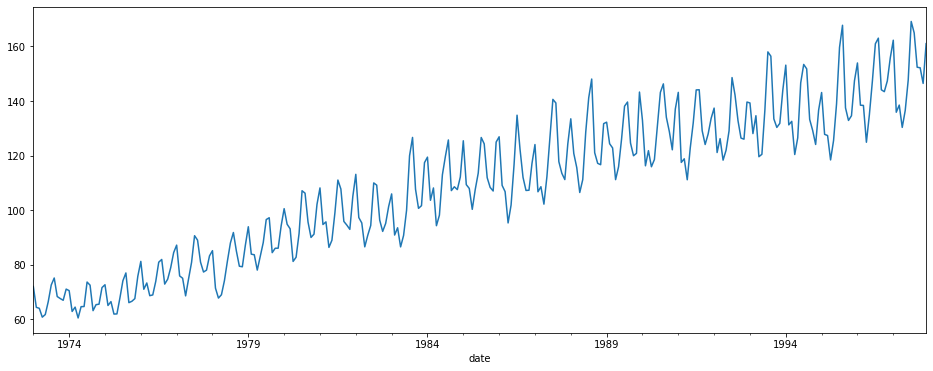

In [7]:
emissions_train.plot(figsize=(16, 6));

Get a feel for the data:
 - Is the magnitude of the variance changing? 
 - Is there seasonality? 
 - Does it have an apparent trend? 

### Q1: Make the time series stationary

In [14]:
emissions_train_log = emissions_train.map(np.log)
emissions_train_log_detrend = emissions_train_log.diff()
emissions_train_log_detrend_without_nans =  emissions_train_log_detrend.dropna()

In [15]:
expected_hash = '0326e5c47adcd7fdcb672aa16aaae11465d0fe01286a73616c19146325111b25'
assert hashlib.sha256(str(np.round(emissions_train_log_detrend_without_nans[0],5)).encode()).hexdigest() == expected_hash

### Q2: Use autocorrelations to look for seasonality.

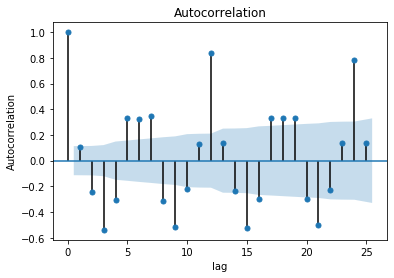

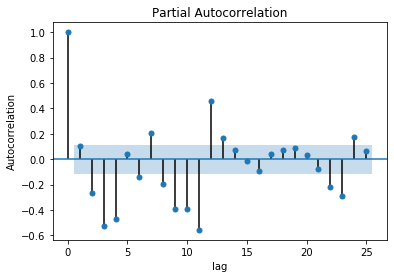

In [26]:
plot_acf(emissions_train_log_detrend_without_nans,alpha=0.05)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

plot_pacf(emissions_train_log_detrend_without_nans,alpha=0.05)  
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

S = 12

In [27]:
assert isinstance(S, int)
expected_hash = '6b51d431df5d7f141cbececcf79edf3dd861c3b4069f0b11661a3eefacbba918'
assert hashlib.sha256(str(S).encode()).hexdigest() == expected_hash

### Q3: Get one-step ahead predictions from a SARIMAX model with S according to what you see in the autocorrelation plots and get the MAE.

Choose the seasonality for your SARIMAX model based on what you have seen on the autocorrelation
Also, for all the SARIMAX models in this notebook you need to select `enforce_stationarity=False` and `enforce_invertibility=False` when creating the model, as shown in the template below.

In [37]:
# hint: one-step ahead is learning notebook 2.
# hint2: given the value of d should you use the emissions_train_log or the detrended version? check notebook 2 

# For the other parameters use:
p = 1
d = 1  # interesting...
q = 1
P = 1
D = 0
Q = 0
S=12

model = SARIMAX(emissions_train_log, order=(p, d, q), seasonal_order=(P, D, Q, S),
               enforce_stationarity=False,
               enforce_invertibility=False)

results = model.fit(maxiter=100)

predictions = results.get_prediction()
# output of the previous code
# <statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper at 0x20e81d4f4e0>

# to have the actual values we have to use the method .predicted.mean
predicted_mean = predictions.predicted_mean

In [35]:
assert isinstance(results, SARIMAXResultsWrapper)
assert isinstance(predictions, PredictionResultsWrapper)
assert predicted_mean.shape == (300,)
expected_hash = 'a71c01c7598f070cc8511f2e0f40247ce1c9b511812c6956b2242b5fb9c5738a'
assert hashlib.sha256(str(np.round(predicted_mean.sum())).encode()).hexdigest() == expected_hash

### Q4: Tunning one-step ahead

### Q4.1 Get the best parameters
Make use of the function `get_best_params` and `get_sarimax_grid` below this cell. Be sure to select the method `AIC` or `validation split`. You must also select the predictive window, which is only used for the latter method.


In [38]:
def get_sarimax_grid():
    p = d = q = P = D = Q = range(0, 2)
    S = 12

    params_combinations = list(itertools.product(p, d, q, P, D, Q))
    inputs = [[x[0], x[1], x[2], x[3], x[4], x[5], S] for x in params_combinations]
    return inputs

In [44]:
def get_best_params(series_, inputs, method ,prediction_window):
    # grid searches over inputs to find the best SARIMAX model for the series_ according to method.
    # The method can be 'aic' or 'validation split' which you learned in the notebooks. For the latter you should
    # select the desired prediction_window
    
    scores = {}
    params_index = {}

    for i in range(len(inputs)):
        # this just prints a kind of progress bar, you can use tqdm if you like 
        print('%0.1f%%' % (i/len(inputs)*100), end=', ')

        param_set = inputs[i]
        if method=='validation split':
            score= get_mae(series_, param_set, prediction_window)
        elif method=='aic':
            score = get_aic(series_, param_set)
        scores[i] = score
        params_index[i] = param_set


    temp = pd.DataFrame(params_index).T
    temp.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'S']
    temp['score'] = pd.Series(scores)
    temp.sort_values('score').head()

    best_model_params = temp.score.idxmin()

    return temp.loc[best_model_params][:-1].astype(int)

In [104]:
# hint: we expect you to use the AIC since this is for one step forecasting.
# hint2: we expect you to use the emissions_train_log, because normally
# it's preferable to let SARIMAX chose the diferencing for us

best_params = get_best_params(emissions_train_log,get_sarimax_grid(),'aic',36).astype('int64')
print("\n")
print(best_params)

0.0%, 1.6%, 3.1%, 4.7%, 6.2%, 7.8%, 9.4%, 10.9%, 12.5%, 14.1%, 15.6%, 17.2%, 18.8%, 20.3%, 21.9%, 

C:\Users\caixi\Anaconda3\envs\BLU05\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


23.4%, 25.0%, 26.6%, 28.1%, 29.7%, 31.2%, 32.8%, 34.4%, 35.9%, 37.5%, 39.1%, 40.6%, 42.2%, 43.8%, 45.3%, 46.9%, 48.4%, 50.0%, 51.6%, 53.1%, 54.7%, 56.2%, 57.8%, 59.4%, 60.9%, 62.5%, 64.1%, 65.6%, 67.2%, 68.8%, 70.3%, 71.9%, 73.4%, 75.0%, 76.6%, 78.1%, 

C:\Users\caixi\Anaconda3\envs\BLU05\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


79.7%, 81.2%, 82.8%, 84.4%, 85.9%, 87.5%, 89.1%, 90.6%, 92.2%, 93.8%, 95.3%, 96.9%, 98.4%, 

p     1
d     1
q     1
P     1
D     0
Q     1
S    12
Name: 61, dtype: int64


In [105]:
assert best_params.shape == (7,)
expected_hash = '7619d28bc856172c56d4ee608f29e82885cdc5b12c3e8a587fea6fa7e7757e45'
assert hashlib.sha256(str(best_params).encode()).hexdigest() == expected_hash

### Q4.2 Use best params to fit SARIMAX and get one-step predictions

In [158]:
# don't forget to set enforce_stationarity and enforce_invertibility as False

model = SARIMAX(emissions_train_log, order=(best_params[:3]), seasonal_order=(best_params[3:]),
               enforce_stationarity=False,
               enforce_invertibility=False)


results = model.fit(maxiter = 100)
predictions = results.get_prediction()
predicted_mean = predictions.predicted_mean
predicted_mean_delogged = predicted_mean.map(np.exp)

In [159]:
assert isinstance(results, SARIMAXResultsWrapper)
assert isinstance(predictions, PredictionResultsWrapper)
assert isinstance(predicted_mean, pd.Series)
assert predicted_mean.shape == (300,)
assert predicted_mean_delogged.shape == (300,)

expected_hash = '2afdd7f1fcff0d88635b41b02139149b84b21a14d98b38cd5a9567b4e5d15c66'
assert hashlib.sha256(str(np.int(predicted_mean_delogged.sum())).encode()).hexdigest() == expected_hash

### Q4.3 Get the MAE for your predictions

In [185]:
# hint: check the end of notebook 2

predicted_mean_delogged_loc = predicted_mean_delogged[1:]
mae = mean_absolute_error(emissions_train[1:],predicted_mean_delogged_loc)

In [187]:
assert predicted_mean_delogged_loc.shape == (299,)
assert isinstance(mae, float)
expected_hash = '4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328cb08b5531fcacdabf8a'
assert hashlib.sha256(str(np.int(mae)).encode()).hexdigest() == expected_hash

### Q4.4 Get the MAE for the one-step ahead baseline

In [199]:
baseline = emissions_train

mae_baseline = mean_absolute_error(baseline[1:],baseline.shift(1).dropna())

In [200]:
assert baseline.shape == (300,)
assert isinstance(mae_baseline, float)
expected_hash = '7902699be42c8a8e46fbbb4501726517e86b22c56a189f7625a6da49081b2451'
assert hashlib.sha256(str(np.int(mae_baseline)).encode()).hexdigest() == expected_hash

### Q5: Use the SARIMAX you've built to predict the test set and get the corresponding MAE

In [202]:
# hint: this is multi-step prediction
# hint2: what did we say in the learning notebook 3 about the size of the prediction 
# window (lenght of the validation set) ?


prediction_window = 36

predictions = results.get_forecast(steps=prediction_window)

predicted_mean = predictions.predicted_mean

predicted_mean_delogged = np.exp(predicted_mean)

mae = mean_absolute_error(emissions_test,predicted_mean_delogged)

In [203]:
assert isinstance(prediction_window, int)
assert isinstance(predictions, PredictionResultsWrapper)
assert isinstance(predicted_mean, pd.Series)
expected_hash = 'e7f6c011776e8db7cd330b54174fd76f7d0216b612387a5ffcfb81e6f0919683'

assert hashlib.sha256(str(np.int(mae)).encode()).hexdigest() == expected_hash

### Q6 Tune the SARIMAX for multi-step forecasting

### Q6.1 Find best params

In [217]:
# hint1: this is multi-step forecasting so we expect you to use the validation split method.

prediction_window = 36
best_params_multistep = get_best_params(emissions_train_log,get_sarimax_grid(),'validation split',prediction_window).astype('int64')

0.0%, 1.6%, 3.1%, 4.7%, 6.2%, 7.8%, 9.4%, 10.9%, 12.5%, 14.1%, 15.6%, 17.2%, 18.8%, 20.3%, 

C:\Users\caixi\Anaconda3\envs\BLU05\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


21.9%, 23.4%, 25.0%, 26.6%, 28.1%, 29.7%, 31.2%, 32.8%, 34.4%, 35.9%, 37.5%, 39.1%, 40.6%, 42.2%, 43.8%, 45.3%, 46.9%, 48.4%, 50.0%, 51.6%, 53.1%, 54.7%, 

C:\Users\caixi\Anaconda3\envs\BLU05\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


56.2%, 57.8%, 59.4%, 60.9%, 62.5%, 64.1%, 

C:\Users\caixi\Anaconda3\envs\BLU05\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\caixi\Anaconda3\envs\BLU05\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


65.6%, 67.2%, 68.8%, 70.3%, 71.9%, 73.4%, 75.0%, 76.6%, 78.1%, 79.7%, 81.2%, 82.8%, 84.4%, 85.9%, 87.5%, 89.1%, 90.6%, 92.2%, 

C:\Users\caixi\Anaconda3\envs\BLU05\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


93.8%, 95.3%, 96.9%, 98.4%, 

In [220]:
assert isinstance(prediction_window, int)
assert isinstance(best_params_multistep, pd.Series)
expected_hash = 'd369f9e8accc3c85b48d84c04261312a56551f884932783ecb1beb9ac04e45df'
assert hashlib.sha256(str(best_params_multistep).encode()).hexdigest() == expected_hash

### Q6.2 Fit SARIMAX with params

In [221]:
model = SARIMAX(emissions_train_log, order=(best_params_multistep[:3]), seasonal_order=(best_params_multistep[3:]),
               enforce_stationarity=False,
               enforce_invertibility=False)


results = model.fit(maxiter = 500)

predictions = results.get_forecast(steps=36)

predicted_mean = predictions.predicted_mean 

predicted_mean_delogged = np.exp(predicted_mean)

mae = mean_absolute_error(emissions_test,predicted_mean_delogged)

In [222]:
assert isinstance(results, SARIMAXResultsWrapper)
assert isinstance(predictions, PredictionResultsWrapper)
assert isinstance(predicted_mean, pd.Series)
assert predicted_mean.shape == (36,)
assert predicted_mean_delogged.shape == (36,)


expected_hash = '4a44dc15364204a80fe80e9039455cc1608281820fe2b24f1e5233ade6af1dd5'
assert hashlib.sha256(str(np.int(mae)).encode()).hexdigest() == expected_hash

**So, which tunning worked best for the multi-step forecasting this time?**